# Context of project :

Date Time: Each ten minutes.
Temperature: Weather Temperature of Tetouan city.
Humidity: Weather Humidity of Tetouan city.
Wind Speed of Tetouan city.
general diffuse flows
diffuse flows
power consumption of zone 1 of Tetouan city.
pow

# Etapes of modelization

## Exploration of the Data

1. Creation of a copy of the data for exploration (sampling it down to a manageable size if necessary).
2. Study each attribute and its characteristics:


-Name


-Type (categorical, int/float, bounded/unbounded, text, structured, etc.)


-Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)


-Possibly useful for the task?


-Type of distribution (Gaussian, uniform, logarithmic, etc.)


4. Identifying of the target attribute(s).
5. Viewing of the data
6. Studying the correlations between attributes.
8. Identifying the promising transformations you may want to apply.
9. Identifying extra data that would be useful (this step is not important for this task)

## Prepare the Data

1. Data cleaning:


• Fix or remove outliers (optional).


• Fill in missing values (e.g., with zero, mean, median…) or drop their rows (or
columns).



2. Feature selection (optional):


• Drop the attributes that provide no useful information for the task.



3. Feature engineering, where appropriate:


• Discretize continuous features.


• Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.).


• Aggregate features into promising new features.



4. Feature scaling: standardize or normalize features.


## Modelisation

1. Train LSTM,XGBoost using standard parameters.
2. Measure and compare their performance.


-For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.


3. Analyze the most significant variables for each algorithm.
4. Analyze the types of errors the models make.



5. Have a quick round of feature selection and engineering.
6. Have one or two more quick iterations of the five previous steps.
7. Short-list the top three to five most promising models, preferring models that make different types of errors.
Fine-Tune the System

1. Fine-tune the hyperparameters using cross-validation.


• Treat your data transformation choices as hyperparameters, especially when
you are not sure about them (e.g., should I replace missing values with zero or
with the median value? Or just drop the rows?).


• Unless there are very few hyperparameter values to explore, prefer random
search over grid search. If training is very long, you may prefer a Bayesian
optimization approach (e.g., using Gaussian process priors, as described by
Jasper Snoek, Hugo Larochelle, and Ryan Adams).


2. Try Ensemble methods. Combining your best models will often perform better than running them individually.


In [403]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from ipywidgets import interact
from scipy.stats import kurtosis
from statsmodels.tsa.stattools import adfuller # for augmented dickey fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # (partial) autocorrelation and autocorrelation functiun
#from statsmodels.tsa.arima.model import ARIMA # ARIMA models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squarred_error
#import statsmodels.api as sm
#import missingno as msn

# Helpers

In [415]:
x_selected1=['hour', 'Temperature', 'months']
x_selected2=['hour', 'months', 'general diffuse flows', 'Temperature', 'Humidity']
x_selected3=['months', 'hour', 'Temperature']

def sanity():
    """The purpose is to be sure that the dataset is clean and the and that the data schema is the same as the one we use as a basis"""
    if((data.isna().sum()).sum()>0):
        data.dropna(inplace=True)

def importation_of_dataset(path_):
    data_consumption=pd.read_csv(path_,index_col=0,parse_dates=['DateTime'])

def box_plot(col):
    sn.boxplot(data_consumption[col])
    plt.title('{}'.format(col))
    
def histplot_(col):
    sn.histplot(data_consumption[col],kde=True)
    
def skew_kurt(col):
    print("The skewness of {} is {} :".format(col,data_consumption[col].skew()))
    #print("The kurtosis ofis {} :".format(kurtosis(data_consumption)))
    
def plot_series(columns_):
    data_consumption[columns_].plot(subplots=True, figsize=(30, 30))        

    
def boxplot_months(x_="months",y_="Zone 1 Power Consumption"):
    plt.figure(figsize=(10,10))
    sn.boxplot(data=df,x=x_,y=y_)
    plt.show()
    
def compute_var(col,y_="Zone 1 Power Consumption"):
    sn.histplot(x=df[col],y=df[y_])
    return plt.show()

def boxplot_min(x_="hour",y_="Zone 1 Power Consumption"):
    plt.figure(figsize=(10,10))
    sn.boxplot(data=df,x=x_,y=y_)
    plt.show()
    
def compute_adfuller(time_series,df):
    stationarized=df[time_series]
    total_order = 0
    if adfuller(df[time_series])[1] > 0.05:
        #difference if the adfuller test p-value is greater than 0.05- test de stationnarite
        diff = (stationarized - stationarized.shift(1)).dropna()    
        stationarized, order = stationarize(diff) # stationarize the difference
        total_order = order + 1
    else :
        print("serie stationnaire")
    return stationarized, total_order



def plot_acf_pacf(ts, fig = None):
    if fig is None:
        fig = plt.figure(figsize=(20, 10))
        sub1 = fig.add_subplot(121)
        #sm.graphics.tsa.plot_acf(ts, ax=sub1,lag=12)
        plot_acf(ts, ax=sub1) # plot acf
        plt.title('ACF')
        
        sub2 = fig.add_subplot(122)
        plot_pacf(ts, ax=sub2, method='ywm') # plot pacf
        plt.title('PACF')
        
        
def decomposition_(ts):
    decomposition = seasonal_decompose(ts.loc["2017-01", "Zone 1 Power Consumption"], period=6*24)
    fig=decomposition.plot()
    fig.set_size_inches((15, 6))
    
def importances_var(name_of_model,features_):
    # Importance des variables
    plt.figure(figsize=(25,25))
    features_important=pd.Series(name_of_model.feature_importances_, index=features_.columns).sort_values(ascending=False)
    sn.barplot(x=features_important.index, y=features_important)
    plt.xlabel("Variables")
    plt.ylabel("score of importance")
    plt.title("Importance of feature")
    plt.show()
    return features_important



def add_month_or_hour(dataset):
    dataset['months']=df.index.map(lambda x: x.month)
    dataset['hour']=df.index.map(lambda x: x.hour)
    return dataset

def selection_of_var(dataset,zone=1):
    dataset=add_month_or_hour(dataset)
    if zone==1:
        dataset=pd.concat([dataset[x_selected1],dataset["Zone 1 Power Consumption"]],axis=1)
    if zone==2:
        dataset=pd.concat([dataset[x_selected2],dataset["Zone 2 Power Consumption"]],axis=1)
    if zone==3:
        dataset=pd.concat([dataset[x_selected3],dataset["Zone 3 Power Consumption"]],axis=1)
    return dataset



def for_standardisation(dataset):
    scaler=MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(dataset),columns=dataset.columns)



def separation_of_dataset(dataset,label_name="Zone 1 Power Consumption",test_size=0.2):
    features=dataset.drop(label_name,axis=1)
    label=dataset[label_name]
    x_train,x_test,y_train,y_test=train_test_split(features,label,test_size=0.2,shuffle=False)
    return x_train,x_test,y_train,y_test



    

# Exploration of data

In [ ]:
data_consumption.head()

In [ ]:
#profile=ProfileReport(
                   # data_consumption,
                    #title="Power forecasting",
                    #html={'style' : {'full_width' :True}}
#)


#profile.to_file(output_file="power forecasting.html")

In [ ]:
data_consumption.describe()

In [ ]:
data_consumption.info()

## Are there any missing value ?

In [ ]:
data_consumption.isna().sum()

## Duplicated values ?

In [ ]:
data_consumption.duplicated().sum()

## Noiness 

In [ ]:
columns_=data_consumption.columns
columns_=columns_.drop("DateTime")

In [ ]:
interact(box_plot,col=columns_)

In [ ]:
# compute a critere of cook to detect the "valeurs aberrantes"

In [ ]:
interact(histplot_,col=columns_)

In [ ]:
zone=["Zone 1 Power Consumption","Zone 2 Power Consumption","Zone 3 Power Consumption"]

In [ ]:
interact(compute_var,col=columns_,y_=zone)

## skewness and kurtosis

In [ ]:
interact(skew_kurt,col=columns_)

## Viewing data

In [ ]:
plot_series(columns_)

### boxplot

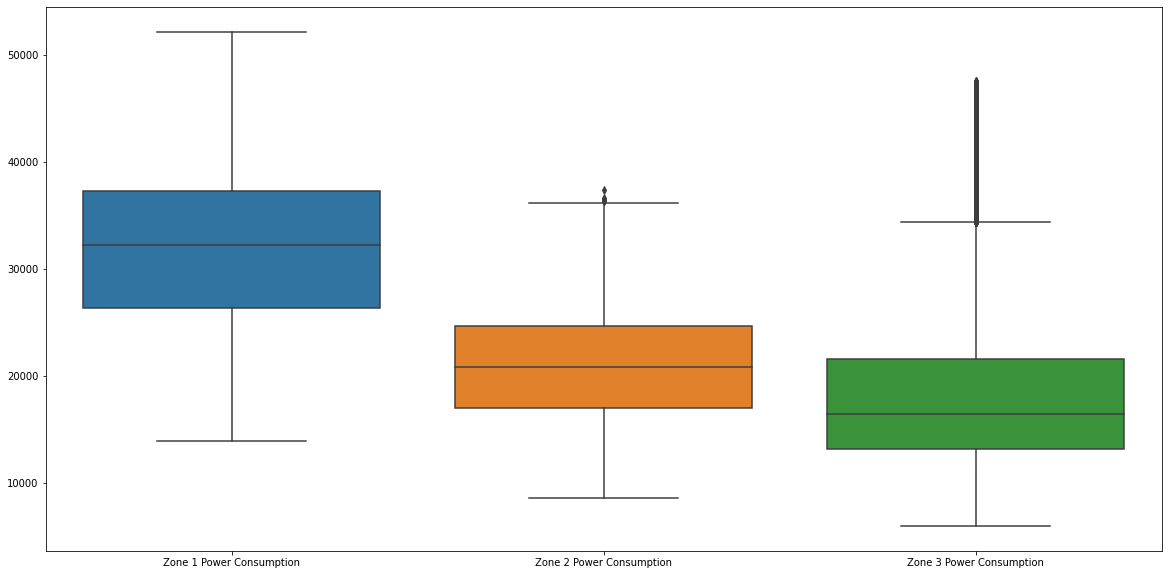

In [289]:
plt.figure(figsize=(20,10))
sn.boxplot(data=df[["Zone 1 Power Consumption","Zone 2 Power Consumption","Zone 3 Power Consumption"]])
plt.show()

In [ ]:
"""On remarque de ces boxplots que la consommation de la zone 3 est relativement tres basse par rapport a celle des autres zones"""

In [ ]:
df=data_consumption.copy()

In [ ]:
"""Afin de pouvoir faire des analyses des donnees par mois et par heure pour voir les mois ou l'energie est la plus consommee et les jours de la zone ou elle l'est egalement nous allons ajouter des features a notre dataset."""

## Ajout de la variable mois

In [ ]:
df['months']=df.index.map(lambda x: x.month)

In [ ]:
df.sample(30)

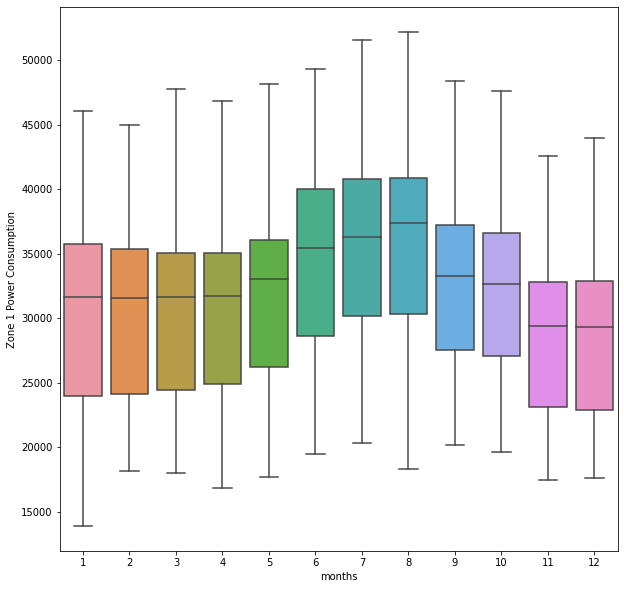

In [290]:
boxplot_months("months","Zone 1 Power Consumption")

In [ ]:
boxplot_months("months","Zone 2 Power Consumption")

In [ ]:
boxplot_months("months","Zone 3 Power Consumption")

In [ ]:
"""On remarque de ces divers boxplots que la consommation d'energie dans les zones 1 et2 connait une hausse entre le 5 et le 8 mois. Cela laisse croire qu'il y a problablement un phenome qui fait que ce mois la consommation d'energie connait une hausse. C'est peut etre les vacances? C'est peut etre une ville touristique ou il fait assez frois pendant ce temps et ils utilisent le chauffage. Par contre, pour la zone 3,le mouvement est un peu plus different. La consommation d'energie connait de hausse le 4 mois en premier lieu, le 6 mois et le 8 avant de redescendre completement"""

## Ajout de la variable heure

In [ ]:
df['hour'] = df.index.hour

In [ ]:
df.head(8)

In [291]:
interact(boxplot_min,x_="hour",y_=zone)

interactive(children=(Text(value='hour', description='x_'), Dropdown(description='y_', options=('Zone 1 Power …

<function __main__.boxplot_min(x_='hour', y_='Zone 1 Power Consumption')>

## correlation

<Axes: >

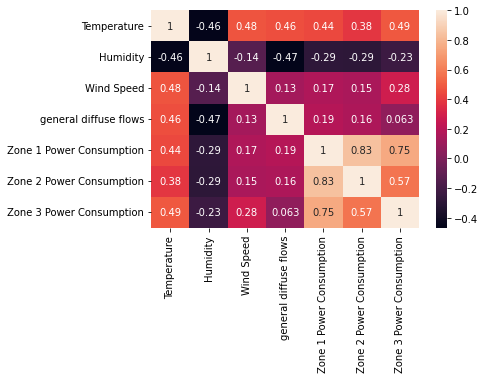

In [286]:
sn.heatmap(df[["Temperature","Humidity","Wind Speed","general diffuse flows","Zone 1 Power Consumption","Zone 2 Power Consumption","Zone 3 Power Consumption"]].corr(),annot=True)

In [287]:
"""En analysant la matrice de correlation, on remarque que la variable general diffuse flows n'est du tout pas correle a la zone 3. Et que la variable Temperature semble moyennement correle a toutes les zones. Pour un debut pour la prediction de la consommation dans la zone 3 nous allons retirer la var general... et pour les autres nous allons garder d'abord toutes les variables et faire une features importances pour selectionner les plus importantes pour chaque modele"""

"En analysant la matrice de correlation, on remarque que la variable general diffuse flows n'est du tout pas correle a la zone 3. Et que la variable Temperature semble moyennement correle a toutes les zones. Pour un debut pour la prediction de la consommation dans la zone 3 nous allons retirer la var general... et pour les autres nous allons garder d'abord toutes les variables et faire une features importances pour selectionner les plus importantes pour chaque modele"

# Stationnarity

In [ ]:
interact(compute_adfuller,time_series=zone)

In [ ]:
"""Toutes nous series sont stationnaires."""

# autocorrelation

In [ ]:
plot_acf_pacf(df["Zone 3 Power Consumption"])

# Decomposition

In [ ]:
decomposition_(df)

# Preparation of data

1. Data cleaning:


• Fix or remove outliers (optional).


• Fill in missing values (e.g., with zero, mean, median…) or drop their rows (or
columns).



2. Feature selection (optional):


• Drop the attributes that provide no useful information for the task.



3. Feature engineering, where appropriate:


• Discretize continuous features.


• Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.).


• Aggregate features into promising new features.

## Feature_selection

In [ ]:
#datasets for prediction of consumption 1,2,3
df1=df.copy()
df2=df.copy()
df3=df.copy()

In [288]:
df1.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,months,hour
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,1,0
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,1,0
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,1,0
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,1,0
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,1,0


In [292]:
df2.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 2 Power Consumption,months,hour
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,16128.87538,1,0
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,19375.07599,1,0
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,19006.68693,1,0
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,18361.09422,1,0
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,17872.34043,1,0


In [ ]:
df1.drop(["Zone 3 Power Consumption","Zone 2 Power Consumption"],axis=1,inplace=True)

In [ ]:
df2.drop(["Zone 3 Power Consumption","Zone 1 Power Consumption"],axis=1,inplace=True)

In [ ]:
df3.drop(["Zone 1 Power Consumption","Zone 2 Power Consumption"],axis=1,inplace=True)

In [ ]:
df3.drop("general diffuse flows",axis=1,inplace=True)

In [ ]:
x_=df1.drop("Zone 1 Power Consumption",axis=1)
y_=df1["Zone 1 Power Consumption"]

## Random Forest for selection of var for first model

In [ ]:
rdf_model1=RandomForestRegressor()
rdf_model1.fit(x_,y_)

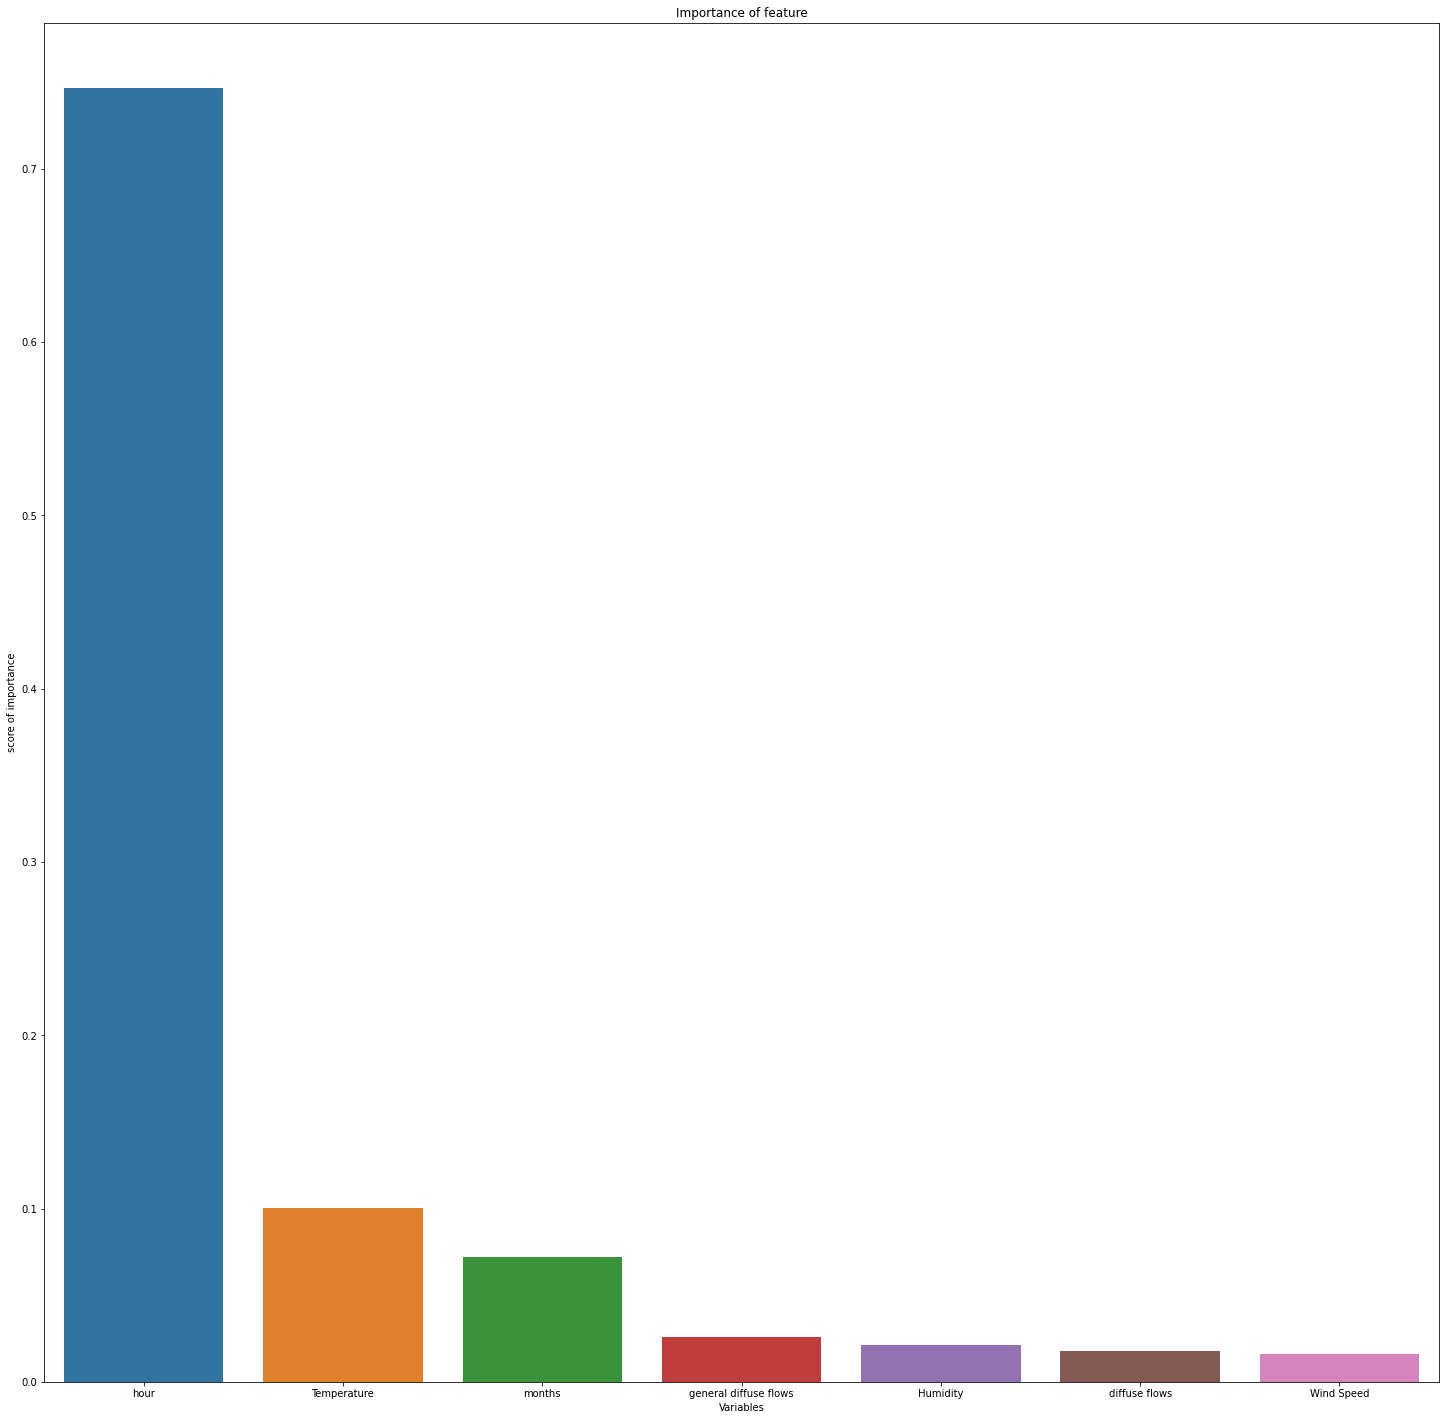

hour                     0.746853
Temperature              0.100372
months                   0.071917
general diffuse flows    0.025989
Humidity                 0.021190
diffuse flows            0.017840
Wind Speed               0.015840
dtype: float64

In [279]:
importances_var(rdf_model1,x_)

In [280]:
features_important>0.03

hour                      True
Temperature               True
months                    True
general diffuse flows    False
Humidity                 False
diffuse flows            False
Wind Speed               False
dtype: bool

In [294]:
seuil=0.03
features_selected=features_important[features_important>seuil].index.to_list()

In [295]:
features_selected

['hour', 'months', 'general diffuse flows', 'Temperature', 'Humidity']

In [293]:
x_selected=x_[features_selected]

## Random Forest for selection of var for second model

In [281]:
x_=df2.drop("Zone 2 Power Consumption",axis=1)
y_=df2["Zone 2 Power Consumption"]

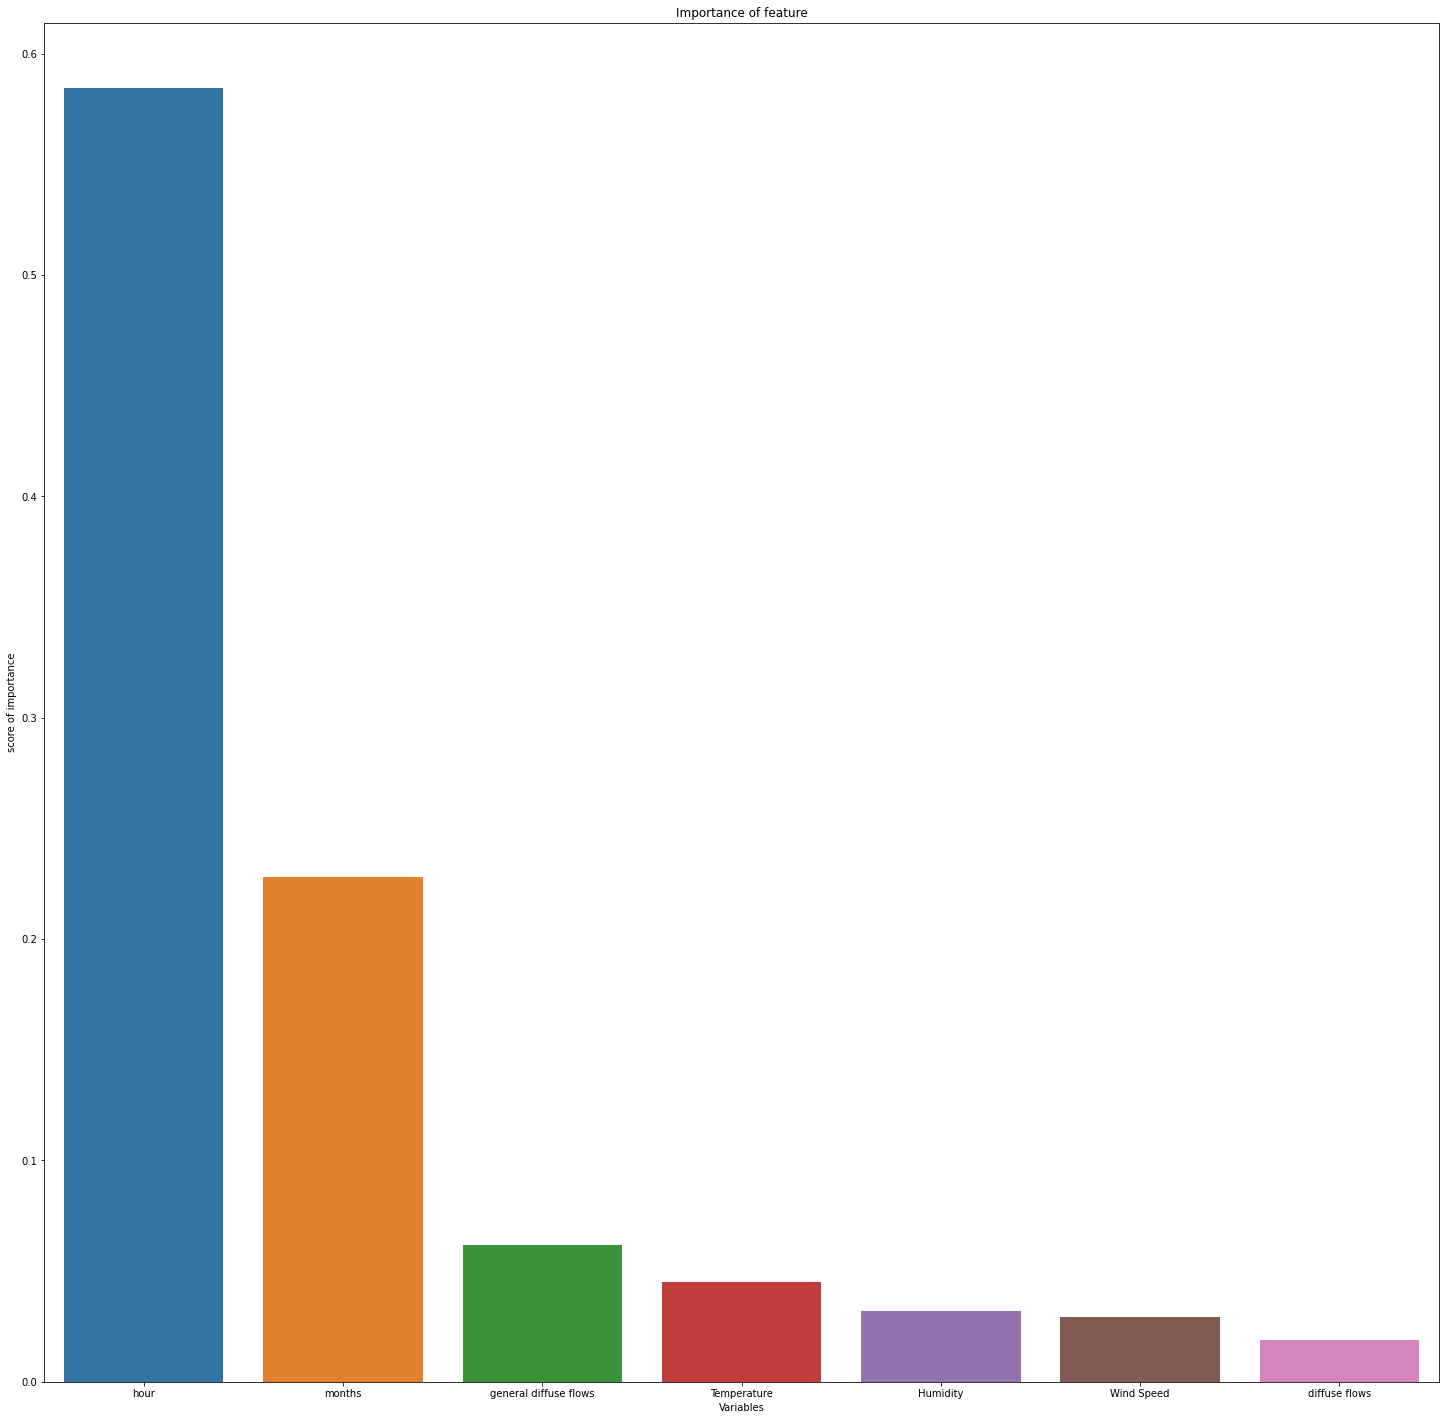

In [283]:
rdf_model2=RandomForestRegressor()
rdf_model2.fit(x_,y_)
features_important=importances_var(rdf_model2,x_)

In [284]:
x_selected2=x_[features_important[features_important>seuil].index.to_list()]

In [285]:
x_selected2

,hour,months,general diffuse flows,Temperature,Humidity
DateTime,,,,,
2017-01-01 00:00:00,0,1,0.051,6.559,73.8
2017-01-01 00:10:00,0,1,0.070,6.414,74.5
2017-01-01 00:20:00,0,1,0.062,6.313,74.5
2017-01-01 00:30:00,0,1,0.091,6.121,75.0
2017-01-01 00:40:00,0,1,0.048,5.921,75.7
...,...,...,...,...,...
2017-12-30 23:10:00,23,12,0.040,7.010,72.4
2017-12-30 23:20:00,23,12,0.051,6.947,72.6
2017-12-30 23:30:00,23,12,0.084,6.900,72.8


## Random Forest for selection of var for third model

In [296]:
x_=df3.drop("Zone 3 Power Consumption",axis=1)
y_=df3["Zone 3 Power Consumption"]

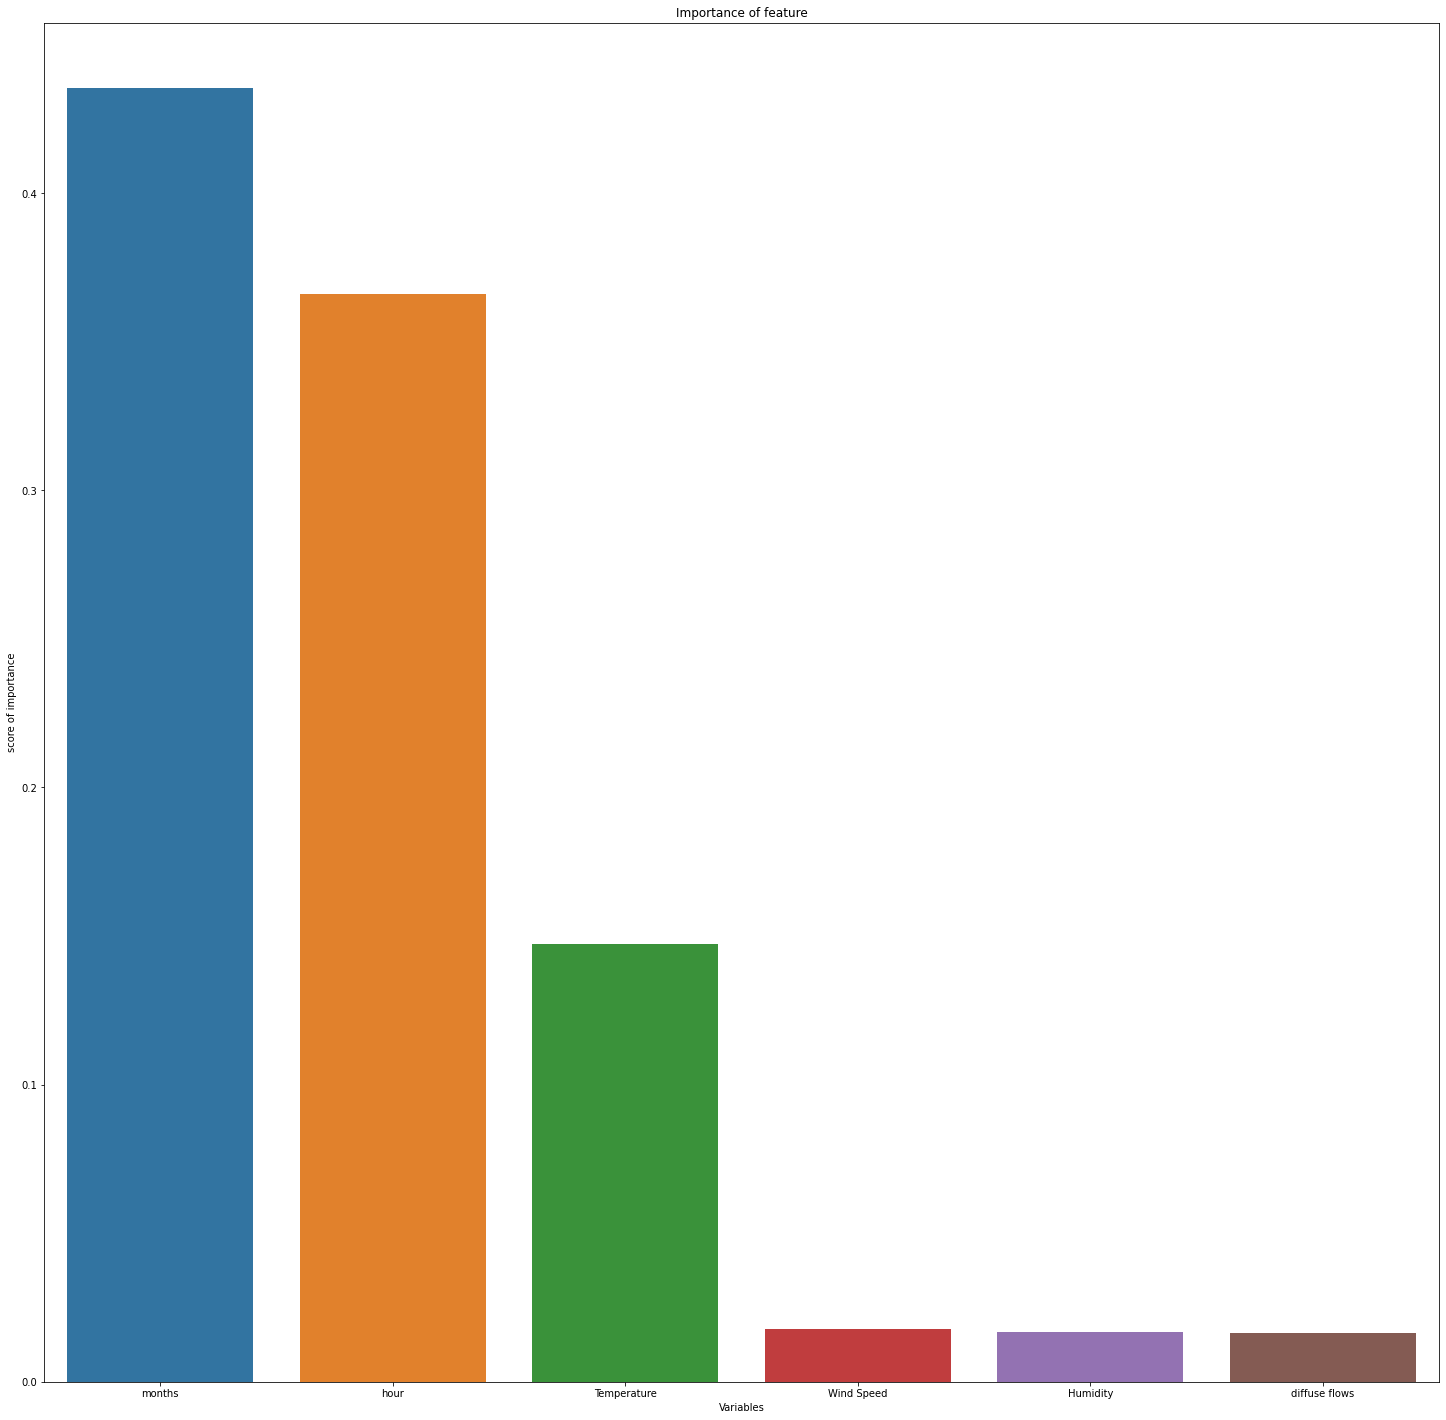

In [297]:
rdf_model3=RandomForestRegressor()
rdf_model3.fit(x_,y_)
features_important=importances_var(rdf_model3,x_)

In [298]:
features_important

months           0.435549
hour             0.366212
Temperature      0.147479
Wind Speed       0.017754
Humidity         0.016656
diffuse flows    0.016351
dtype: float64

In [300]:
x_selected3=x_[features_important[features_important>seuil].index.to_list()]

In [312]:
x_selected3.tail(5)

,months,hour,Temperature
DateTime,,,
2017-12-30 23:10:00,12,23,7.010
2017-12-30 23:20:00,12,23,6.947
2017-12-30 23:30:00,12,23,6.900
2017-12-30 23:40:00,12,23,6.758
2017-12-30 23:50:00,12,23,6.580


In [302]:
"""Nous avons donc selectionnees nos variables pour les trois modeles"""

'Nous avons donc selectionnees nos variables pour les trois modeles'

# Feature Engineering

## Feature scaling: standardize or values

In [400]:
df1=pd.concat([x_selected,df["Zone 1 Power Consumption"]],axis=1)

In [420]:
data_consumption

In [408]:
df1_standardisation=for_standardisation(df1)

In [409]:
df1_standardisation

,hour,Temperature,months,Zone 1 Power Consumption
0,0.0,0.090091,0.0,0.526251
1,0.0,0.086146,0.0,0.415545
2,0.0,0.083399,0.0,0.397623
3,0.0,0.078176,0.0,0.374149
4,0.0,0.072736,0.0,0.350834
...,...,...,...,...
52411,1.0,0.102358,1.0,0.450675
52412,1.0,0.100645,1.0,0.431618
52413,1.0,0.099366,1.0,0.409703
52414,1.0,0.095504,1.0,0.393187


# Separation de la dataset

In [411]:
x_train1,x_test1,y_train1,y_test1=separation_of_dataset(df1_standardisation)

# Modelization

## Random forest optimiser

In [ ]:
seed=999

In [ ]:
param_grid={'n_estimators' : [10,20,30],
            'min_samples_split' :[4,8,10,20,30,40,50],
            'max_leaf_nodes':[2,4,8,10,20,30],
            'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
            'max_features' : ["sqrt", "log2", None],
           'max_depth' : [2,4,3,5, None]}

random_model_Zone1=GridSearchCV(estimator=RandomForestRegressor(random_state=seed), param_grid=param_grid,scoring='neg_mean_squared_error',cv=5)

random_model_Zone1=random_model_Zone1.fit(x_train1,y_train1)

#best score
print(round(random_model_Zone1.best_score_,3))
print(random_model_Zone1.best_estimator_)

In [ ]:
## XGBoost

In [ ]:
n_estimators=1000
xgboost_model,scores=training.train_xgboost(x_train1,y_train1,x_test1,y_test1,n_estimators=n_estimators,b_feat_importance=True,b_verbose=False

In [ ]:
# LSTM

In [ ]:
def transformation_for_lstm(x_train):
    x_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1])
    

In [ ]:
# set LSTM neural network
model = Sequential()
# build model
model.add(LSTM(units=30, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(units=1))
# set compiler
optimizer = Adam(lr=0.01561601307656165)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])